In [3]:
!pip install opencv-contrib-python==3.3.0.10
import numpy as np 
import cv2
import math 
import os
import matplotlib.pyplot as plt
from random import sample

     |████████████████████████████████| 21.4MB 43.5MB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [24]:
# below is the code for finding the sift point correspondences. 
# inputs to the function are the 2 image paths
#NOTE: The whole code is based on colored RGB images
def point_correspondences(img1_path,img2_path):
    img1 = cv2.cvtColor(cv2.imread(img1_path),cv2.COLOR_BGR2RGB) #converting to a grayscale image
    img2 = cv2.cvtColor(cv2.imread(img2_path),cv2.COLOR_BGR2RGB)
    sift = cv2.xfeatures2d.SIFT_create()                          #initializing the sift algorithm
    img1_keys, img1_desc = sift.detectAndCompute(img1,None)       #computing the keypoints and the descriptors
    img2_keys, img2_desc = sift.detectAndCompute(img2,None)
    img1_keys = np.array(cv2.KeyPoint_convert(img1_keys))         #converting the keypoints to numpy array
    img2_keys = np.array(cv2.KeyPoint_convert(img2_keys))

    img1_keys,img1_desc = keypoints_preprocessing(img1_keys,img1_desc)  #prprocessing of keypoints and descriptors
    img2_keys,img2_desc = keypoints_preprocessing(img2_keys,img2_desc)
    
    if len(img1_keys)<=len(img2_keys):                  #based on the number of keypoints, I decided the reference image and corresponding image
        ref_pts = img1_keys
        ref_desc = img1_desc
        corr_pts = img2_keys
        corr_desc = img2_desc
        print("img1 is reference image and img2 is corresponding image")
    else:
        ref_pts = img2_keys
        ref_desc = img2_desc
        corr_pts = img1_keys
        corr_desc = img1_desc
        print("img2 is reference image and img1 is corresponding image")
    
    distances = {}      #this dictionary will store the point correspondences as values and the L2 norm of the descriptors as keys
    for i in range(len(ref_pts)):
        distance = 10000000000000
        cpt = None
        for j in range(len(corr_pts)):
            dist = np.linalg.norm(ref_desc[i,:]-corr_desc[j,:])
            if dist < distance:
                distance = dist 
                cpt = corr_pts[j,:]
        distances[distance] = [ref_pts[i,:],cpt]
    return distances        

def keypoints_preprocessing(keypoints,desc):
    kp = np.zeros(keypoints.shape) 
    kp[:,0] = keypoints[:,1]      #interchanging the x,y coordinates of the keypoints as cv2 gives out (width,height)
    kp[:,1] = keypoints[:,0]   
    uniq_kp, uniq_ind = np.unique(kp,return_index=True,axis=0)  #removing the repetitive keypoints and descriptors
    uniq_desc = desc[uniq_ind,:]
    return uniq_kp,uniq_desc

def A(pt1,pt2):         #given two points 'A' function will compute the row for the A matrix (DLT method)
    x,y = pt1
    x1,y1 = pt2
    A = np.array([x*x1,y*x1,x1,x*y1,y*y1,y1,x,y,1])
    return A
 
def funda_mat(ref_tmp,corr_tmp):   #calculation of the fundamental matrix using the point correspondences
    A1 = np.zeros((len(ref_tmp),9)) #initializing the A matrix 
    for i in range(len(ref_tmp)):
        A1[i,:] = A(ref_tmp[i,:],corr_tmp[i,:])
    _,_,vh = np.linalg.svd(A1)  #calculating the svd 
    F = vh[8,:].reshape((3,3)) #F = last row of V.T
    return F

def line_pt_dist(line,pt):    #this function finds the distance between a line and a point
    a,b,c = line
    x,y = pt
    pt_mod = np.array([[x],[y],[1]])
    dist = abs(np.matmul(line.T,pt_mod))/math.sqrt((a**2)+(b**2))
    return dist

#the below function is used to sample the points and calculate the fundamental matrix
#The below function assumes that the point correspondences having the least L2 norm (of the descriptors) are 
#the best fit for the fundamental matrix. Inshort, this is a NON RANSAC method.
#The INPUTS to this function are the distances(from the point_correspondences function) and n(the number
#of points to be sampled for the calculation of the fundamental matrix)
def fundamental_matrix_calc(distances,n):  
    dist = np.array(list(distances.keys()))
    dist_sorted = np.sort(dist)
    ref_tmp = np.zeros((n,2))
    corr_tmp = np.zeros((n,2))
    for i in range(n):
        ref_tmp[i,:] = distances[dist_sorted[i]][0]
        corr_tmp[i,:] = distances[dist_sorted[i]][1]
    F = funda_mat(ref_tmp,corr_tmp)
    satisfied = 0 
    for i in range(100):       #accuracy checking is done for first 100 point correspondences having the least L2 norm (of descriptors)
        ref,corr = distances[dist_sorted[i]]
        x,y = ref
        line = np.matmul(F,np.array([[x],[y],[1]]))
        error = line_pt_dist(line,corr)[0]
        if error<5:
            satisfied+=1
    return F,satisfied

# below function is the code for the reference image reconstruction using the correponding image
# NOTE: patch size assumed is (3,3). after finding the closest patch only the central pixel is replaced 
# NOTE: The reference image and corresponding image should be taken care of for good results

def image_reconstruction(ref_img_path,corr_img_path,F):
    ref_img = cv2.imread(ref_img_path) #reading the ref and corr images 
    corr_img = cv2.imread(corr_img_path)
    ref_m,ref_n,_ = ref_img.shape                 #extracting the shapes of the images
    corr_m,corr_n,_ = corr_img.shape
    reconstructed_image = np.zeros(ref_img.shape)  #initializing the reconstructed image 
    x = np.array(range(corr_m))                    #initializing x for x,y along the epipolar line
    for i in range(ref_m):                         #code for finding the closest patch and inserting the pixel values in reconstructed image.
        for j in range(ref_n):
            #print( i, j)
            ep_line = np.matmul(F,np.array([[i],[j],[1]])) #calculating the epipolar line
            a,b,c = ep_line
            y = -((a*x) + c)/b                       #y coordinates of the epipolar line
            y1 = np.int64(np.floor(y))
            y2 = np.int64(np.ceil(y))               #rounding off and changing the datatype of y 
            if i not in [0,ref_m-1] and j not in [0,ref_n-1]:  #excluding the borders of the image
                ref_patch = ref_img[i-1:i+2,j-1:j+2,:]           # reference patch
                dict_error = {}                                #this dictionary contains keys: ref and test patch error (L1 norm) values: corresponding (x,y) coordinates along epipolar line
                
                for k in range(len(y)):
                    if 0<x[k]<corr_m-1 and 0<y1[k]<corr_n-1 and 0<y2[k]<corr_n-1:   #(x,y) should be within the image
                        test_patch1 = corr_img[x[k]-1:x[k]+2,y1[k]-1:y1[k]+2,:]
                        test_patch2 = corr_img[x[k]-1:x[k]+2,y2[k]-1:y2[k]+2,:]
                        error1 = sum(sum(sum(abs(ref_patch - test_patch1))))
                        error2 = sum(sum(sum(abs(ref_patch - test_patch2))))
                        if error1<error2:
                            dict_error[error1] = [x[k],y1[k]]
                        else:
                            dict_error[error2] = [x[k],y2[k]]
                #print('dict_error is',dict_error)
                if len(list(dict_error.keys()))>0:
                    min_error = np.min(np.array(list(dict_error.keys())))
                    reconstructed_image[i,j,:] = corr_img[dict_error[min_error][0],dict_error[min_error][1],:] #insserting the pixel intensity of (x,y) showing min patch error
    return reconstructed_image



#the below function is used for calculating the fundamental matrix (RANSAC method)
#The function takes iterations, distances(obtained from point_correspondences function), n (no. of points for F), threshold
#NOTE: The first (threshold) point correspondences having least L2 norm have been considered and the best sample is 
#found which gives the maximum accuracy for the first (threshold) points.
def fundamental_matrix_calc_mod(iter,distances,n,threshold):
    dist = np.array(list(distances.keys())) #extracting the L2 norms from the distances 
    dist_sorted = np.sort(dist)             #sorting the L2 norms
    idxs= []                                #this list stores the samples extracted for all iterations
    F_main = None                           #best Fundamental matrix
    accuracy = 0                            #initializing the accuracy
    it = 0                                  #initializing iterations = 0 
    while it<iter:
        idx = list(np.random.choice(np.arange(300), n, replace=False)) #sampling from the first 100 indices
        if idx not in idxs:                    #ensuring the sampling is unique for all the iterations
            #print(it)
            idxs.append(idx)                   #appending the sampled indices
            ref_tmp = np.zeros((n,2))         
            corr_tmp = np.zeros((n,2))
            for i in range(n):                   #extracting the sampled ref and corr pts
                ref_tmp[i,:] = distances[dist_sorted[idx[i]]][0]
                corr_tmp[i,:] = distances[dist_sorted[idx[i]]][1]
            F = funda_mat(ref_tmp,corr_tmp)       # finding the fundamental matrix
            satisfied = 0                         #satisfied points initialization
            for i in range(threshold):                  
                ref,corr = distances[dist_sorted[i]]
                x,y = ref
                line = np.matmul(F,np.array([[x],[y],[1]]))
                error = line_pt_dist(line,corr)[0]
                if error<5:                #the distance between epipolar line and pt should be less than 5
                    satisfied+=1
            if satisfied>accuracy: 
                F_main = F
                accuracy = satisfied
            it = it+1
    return F_main,accuracy/threshold

RUN THE CODE FROM HERE

In [5]:
img1_path = '/content/imL.bmp'  #img1_path 
img2_path = '/content/imR.bmp'  #img2_path
distances = point_correspondences(img1_path,img2_path) #finding the distances dictionary
print(len(distances))
#F,accuracy = fundamental_matrix_calc_mod(1500,distances,8,len(distances))  #fundamental matrix and accuracy for the first (threshold) number of point correspondences
#print(accuracy)

img2 is reference image and img1 is corresponding image
699


In [27]:
F,accuracy = fundamental_matrix_calc_mod(10000,distances,8,300)  #fundamental matrix and accuracy for the first (threshold) number of point correspondences
print(accuracy)

0.93


In [28]:
reconstructed_image = image_reconstruction(img2_path,img1_path,F) #reconstruct the ref image from the corresponding image

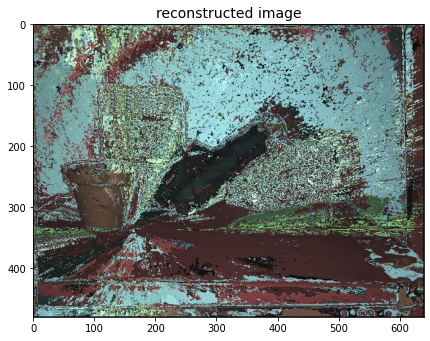

In [29]:
#plotting the reconstructed image
reconstructed_image_ = cv2.cvtColor(np.uint8(reconstructed_image),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,10))
plt.imshow(np.int32(reconstructed_image_))
plt.title('reconstructed image', size = 14)
plt.savefig('/content/reconstructed_img.jpg')

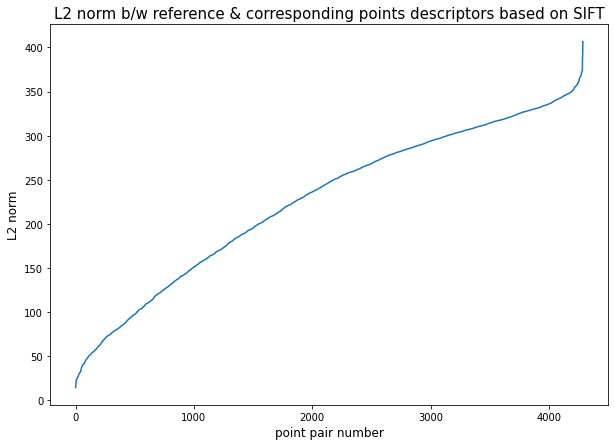

In [ ]:
#this plot gives how much is the L2 norm varying in the point correspondences
plt.figure(figsize=(10,7))
dist_sorted = np.sort(np.array(list(distances.keys())))
plt.plot(np.array(range(len(dist_sorted))),dist_sorted)
plt.title('L2 norm b/w reference & corresponding points descriptors based on SIFT',size = 15)
plt.xlabel('point pair number',size = 12)
plt.ylabel('L2 norm',size = 12)
plt.savefig('/content/distance_variation.jpg')
#This plot shows that only some points have very less L2 norm implying only few good point correspondences

COMPARISION WITH INBUILT FUNCTION

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1_path = '/content/imL.bmp'  #img1_path 
img2_path = '/content/imR.bmp'  #img2_path

img1 = cv2.cvtColor(cv2.imread(img2_path),cv2.COLOR_BGR2GRAY) #converting to a grayscale image
img2 = cv2.cvtColor(cv2.imread(img1_path),cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F_inbuilt, mask = cv2.findFundamentalMat(pts2,pts1,cv2.FM_LMEDS)
recons_img_inbuilt = image_reconstruction(img2_path,img1_path,F_inbuilt)

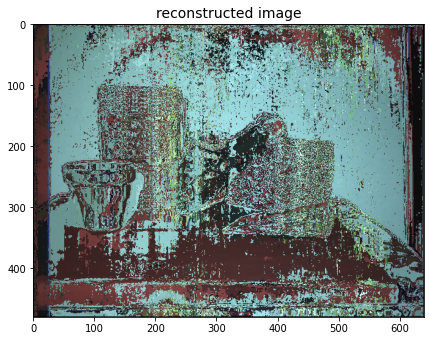

In [31]:
#plotting the reconstructed image
recons_img_inbuilt_ = cv2.cvtColor(np.uint8(recons_img_inbuilt),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,10))
plt.imshow(recons_img_inbuilt_)
plt.title('reconstructed image', size = 14)
plt.savefig('/content/reconstructed_img_inbuilt.jpg')